In [17]:
from configs import cfg
#  Copyright (c) 2021, Omid Erfanmanesh, All rights reserved.

import random

import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from pandas import DataFrame
from scipy import stats
from sklearn.model_selection import train_test_split

from data.based.file_types import FileTypes
from data.based.sampling_types import Sampling
from data.based.transformers_enums import TransformersType

seed = 2021
np.random.seed(seed)
random.seed(seed)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)

*BasedDataset* contains functions that are related to manipulate the dataset.

In [18]:



class BasedDataset:

    def __init__(self, cfg, dataset_type):

        self._cfg = cfg
        self.dataset_type = dataset_type
        self.dataset_address = cfg.DATASET.DATASET_ADDRESS
        self.target_col = cfg.DATASET.TARGET
        self.dataset_description_file = cfg.DATASET.DATASET_BRIEF_DESCRIPTION

        if self.dataset_description_file is not None:
            self.about = self.__open_txt_file(self.dataset_description_file)

        self.load_dataset()
        self.df = self.df_main.copy()
        self.pca = None
        self.encoded_data = None
        self.scaled_data = None

    def load_dataset(self):
        """
        load dataset from csv file to dataframe
        """
        if self.dataset_type == FileTypes.CSV:
            self.df_main = self.__create_csv_dataframe()
        else:
            raise ValueError('dataset should be CSV file')

    def drop_cols(self):
        """
        drop columns from df

        """
        if self._cfg.DATASET.DROP_COLS is not None:
            cols = list(self._cfg.DATASET.DROP_COLS)
            self.df = self.df.drop(labels=cols, axis=1)

    def transform(self, data, trans_type):
        """
        change the distribution of data by using log transformation, ...

        :param data:
        :param trans_type:
        :return:
        """
        _min = min(data)
        if _min <= 0:
            data = data + 1 - _min
        try:
            if trans_type == TransformersType.LOG:
                data = np.log(data)
            elif trans_type == TransformersType.SQRT:
                data = np.sqrt(data)
            elif trans_type == TransformersType.BOX_COX:
                data = stats.boxcox(data)[0]
        except Exception as e:
            print('transform can not be applied')

        return data

    def categorical_features(self, data=None):
        """
        select just categorical features from df

        :param data:
        :return:
        """
        if data is None:
            return self.df.select_dtypes(include=['object']).columns.tolist()
        else:
            return data.select_dtypes(include=['object']).columns.tolist()

    def numerical_features(self, data=None):
        """
         select just numerical features from df

        :param data:
        :return:
        """
        if data is None:
            return self.df.select_dtypes(exclude=['object']).columns.tolist()
        else:
            return data.select_dtypes(exclude=['object']).columns.tolist()

    def select_columns(self, data, cols=None, just_numerical=False):
        """
        select columns from df

        :param data:
        :param cols: array of columns that will be selected, None means select numerical features
        :param just_numerical:
        :return:
        """
        if cols is None or just_numerical:
            cols = self.numerical_features(data=data)
        return data[cols]

    def split_to(self, test_size=0.10, val_size=0.10, has_validation=False, use_pca=False, random_state=seed):
        """
        split dataset to train, test, validation set.

        :param test_size: size of test set
        :param val_size: size of validation set
        :param has_validation: set True if validation set is required
        :param use_pca: split dataset from pca components
        :param random_state:
        :return:
        """
        _X, _y = self.__samples_and_labels(use_pca=use_pca)

        _X_train, _X_test, _y_train, _y_test = train_test_split(_X, _y, test_size=test_size, random_state=random_state)
        if has_validation:
            _X_train, _X_val, _y_train, y_val = train_test_split(_X_train, _y_train, test_size=val_size,
                                                                 random_state=random_state)
            return _X_train, _X_val, _X_test, _y_train, y_val, _y_test
        else:
            return _X_train, _X_test, _y_train, _y_test

    def generate_new_column_name(self, col, prefix):
        """
        generate new name for columns

        :param col:
        :param prefix:
        :return:
        """
        return '{}_{}'.format(col, prefix)

    def __samples_and_labels(self, use_pca=False):
        """
        return data as X and target values as y

        :param use_pca: select X from pca
        :return: data and label from df or pca
        """
        _X = None
        _y = None
        if use_pca:
            if self.pca is not None:
                _X = self.pca.copy().drop(labels=[self.target_col], axis=1)
                _y = self.pca[self.target_col].copy()
            else:
                print('pca data frame is not provided')
        else:
            _X = self.df.copy().drop(labels=[self.target_col], axis=1)
            _y = self.df[self.target_col].copy()

        return _X, _y

    def resampling(self, X, y):
        """
        resample dataset if you have imbalance data

        :param X: data
        :param y: targets
        :return: return new data with resampling strategy
        """

        if self._cfg.BASIC.SAMPLING_STRATEGY is None:
            raise ValueError(" SAMPLING_STRATEGY is None, Check the defaults.py")

        steps = []
        if type(self._cfg.BASIC.SAMPLING_STRATEGY) is tuple:
            sampling_types = [*self._cfg.BASIC.SAMPLING_STRATEGY]
            for smp in sampling_types:
                step = self.__resampling_pipeline(sampling_type=smp)
                steps.append(step)
        else:
            sampling_types = self._cfg.BASIC.SAMPLING_STRATEGY
            step = self.__resampling_pipeline(sampling_type=sampling_types)
            steps.append(step)

        pipeline = Pipeline(steps=steps)
        X, y = pipeline.fit_resample(X, y)
        return X, y

    def __resampling_pipeline(self, sampling_type):
        """
        create a pipeline for resampling data

        :param sampling_type:
        :return: a pipeline contains resampling strategies
        """
        steps = None

        if sampling_type == Sampling.RANDOM_UNDER_SAMPLING:

            params = {
                'sampling_strategy': self._cfg.RANDOM_UNDER_SAMPLER.SAMPLING_STRATEGY,
                'random_state': self._cfg.RANDOM_UNDER_SAMPLER.RANDOM_STATE,
                'replacement': self._cfg.RANDOM_UNDER_SAMPLER.REPLACEMENT
            }
            random_under_sampler = RandomUnderSampler(**params)
            steps = ('random_under_sampler', random_under_sampler)
        elif sampling_type == Sampling.RANDOM_OVER_SAMPLING:
            params = {
                'sampling_strategy': self._cfg.RANDOM_OVER_SAMPLER.SAMPLING_STRATEGY,
                'random_state': self._cfg.RANDOM_OVER_SAMPLER.RANDOM_STATE,
                # 'shrinkage': self._cfg.RANDOM_OVER_SAMPLER.SHRINKAGE
            }
            random_over_sampler = RandomOverSampler(**params)
            steps = ('random_over_sampler', random_over_sampler)
        elif sampling_type == Sampling.SMOTE:
            params = {
                'sampling_strategy': self._cfg.SMOTE.SAMPLING_STRATEGY,
                'random_state': self._cfg.SMOTE.RANDOM_STATE,
                'k_neighbors': self._cfg.SMOTE.K_NEIGHBORS,
                'n_jobs': self._cfg.SMOTE.N_JOBS
            }
            smote = SMOTE(**params)
            steps = ('smote', smote)
        elif sampling_type == Sampling.SMOTENC:
            params = {
                'categorical_features': self._cfg.SMOTENC.CATEGORICAL_FEATURES,
                'sampling_strategy': self._cfg.SMOTENC.SAMPLING_STRATEGY,
                'random_state': self._cfg.SMOTENC.RANDOM_STATE,
                'k_neighbors': self._cfg.SMOTENC.K_NEIGHBORS,
                'n_jobs': self._cfg.SMOTENC.N_JOBS
            }
            smotenc = SMOTENC(**params)
            steps = ('smotenc', smotenc)
        elif sampling_type == Sampling.SVMSMOTE:
            params = {
                'sampling_strategy': self._cfg.SVMSMOTE.SAMPLING_STRATEGY,
                'random_state': self._cfg.SVMSMOTE.RANDOM_STATE,
                'k_neighbors': self._cfg.SVMSMOTE.K_NEIGHBORS,
                'n_jobs': self._cfg.SVMSMOTE.N_JOBS,
                'm_neighbors': self._cfg.SVMSMOTE.M_NEIGHBORS,
                # 'svm_estimator': self._cfg.SMOTE.SVM_ESTIMATOR,
                'out_step': self._cfg.SVMSMOTE.OUT_STEP
            }
            svmsmote = SVMSMOTE(**params)
            steps = ('svmsmote', svmsmote)

        return steps

    def __create_csv_dataframe(self):
        """
        read data from csv file
        :return: pandas dataframe
        """
        return pd.read_csv(self.dataset_address, delimiter=';')

    def __open_txt_file(self, desc):
        """
        read contents from txt file
        :param desc:
        :return: contents as text
        """
        return open(desc, 'r').read()

    @property
    def df(self):
        return self._df

    @df.setter
    def df(self, df: DataFrame):
        self._df = df

    @property
    def pca(self):
        return self._pca

    @pca.setter
    def pca(self, value):
        self._pca = value

    @property
    def df_main(self):
        return self._df_main

    @df_main.setter
    def df_main(self, value):
        self._df_main = value

    @property
    def dataset_address(self):
        return self._dataset_address

    @dataset_address.setter
    def dataset_address(self, address):
        self._dataset_address = address

    @property
    def dataset_type(self):
        return self._dataset_type

    @dataset_type.setter
    def dataset_type(self, value):
        self._dataset_type = value

    @property
    def target_col(self):
        return self._target_col

    @target_col.setter
    def target_col(self, target):
        self._target_col = target

    @property
    def targets(self):
        return self.df_main[self.target_col]

    @property
    def about(self):
        return self._about

    @about.setter
    def about(self, about):
        self._about = about

    @property
    def dataset_description_file(self):
        return self._dataset_description_file

    @dataset_description_file.setter
    def dataset_description_file(self, value):
        self._dataset_description_file = value

    @property
    def encoded_data(self):
        return self._encoded_data

    @encoded_data.setter
    def encoded_data(self, value):
        self._encoded_data = value

    @property
    def scaled_data(self):
        return self._scaled_data

    @scaled_data.setter
    def scaled_data(self, value):
        self._scaled_data = value

*Bank* is a sub-class of *BasedDataset*. It contains functions that are related to manipulate the dataset.
The functions are named equaly to each column of csv file

In [19]:
from data.based.file_types import FileTypes


class Bank(BasedDataset):
    def __init__(self, cfg):
        super(Bank, self).__init__(cfg=cfg, dataset_type=FileTypes.CSV)

    def age(self):
        self.df.loc[self.df['age'] <= 32, 'age'] = 1
        self.df.loc[(self.df['age'] > 32) & (self.df['age'] <= 47), 'age'] = 2
        self.df.loc[(self.df['age'] > 47) & (self.df['age'] <= 70), 'age'] = 3
        self.df.loc[(self.df['age'] > 70) & (self.df['age'] <= 98), 'age'] = 4

    def job(self):
        pass

    def marital(self):
        pass

    def education(self):
        pass

    def default(self):
        pass

    def balance(self):
        pass

    def housing(self):
        pass

    def loan(self):
        pass

    def contact(self):
        pass

    def day(self):
        pass

    def month(self):
        pass

    def duration(self):
        self.df.loc[self.df['duration'] <= 102, 'duration'] = 1
        self.df.loc[(self.df['duration'] > 102) & (self.df['duration'] <= 180), 'duration'] = 2
        self.df.loc[(self.df['duration'] > 180) & (self.df['duration'] <= 319), 'duration'] = 3
        self.df.loc[(self.df['duration'] > 319) & (self.df['duration'] <= 644.5), 'duration'] = 4
        self.df.loc[self.df['duration'] > 644.5, 'duration'] = 5

    def campaign(self):
        pass

    def pdays(self):
        pass

    def previous(self):
        pass

    def poutcome(self):
        self.df['poutcome'].replace(['nonexistent', 'failure', 'success'], [1, 2, 3], inplace=True)

    def y(self):
        pass

In [20]:
def load(cfg):
    bank = Bank(cfg=cfg)
    return bank


To apply principal component analysis, use *PCA* Class

In [21]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA as skl_pca

sns.set()



class PCA:
    def __init__(self, cfg):
        self.n_components = cfg.PCA.N_COMPONENTS
        self.pca = skl_pca(n_components=self.n_components, random_state=cfg.BASIC.RAND_STATE)

    def do_pca(self, data, y):
        """
        apply pca to data
        :param data:
        :return: dataframe of pca components
        """
        _components = self.pca.fit_transform(data)
        print('Explained variance: %.4f' % self.pca.explained_variance_ratio_.sum())
        print('Individual variance contributions:')
        for j in range(self.pca.n_components_):
            print(self.pca.explained_variance_ratio_[j])

        _columns = ['pc' + str(i + 1) for i in range(self.pca.n_components_)]
        _columns.append('y')

        y = np.reshape(y.values, (y.values.shape[0], -1)).copy()
        _components = np.concatenate((_components, y), axis=1)
        _pca_df = pd.DataFrame(data=_components
                               , columns=_columns)

        return _pca_df

    def plot(self, X, y):
        """
        scatter plot of pca components
        :param X:
        :param y:
        """
        X['y'] = y
        sns.pairplot(X, hue="y", height=2.5)
        plt.show()

*Scaler* Class provides functions that are needed to change scale of data

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from data.based.scale_types import ScaleTypes



class Scalers:
    def __init__(self, cfg):
        self._cfg = cfg

    def __get_scaler(self, scale_type):
        """
        get scaler object
        :param scale_type:
        :return: scaler object, name of scaler
        """
        scl = None
        scl_name = None
        if scale_type == ScaleTypes.MIN_MAX:
            scl = MinMaxScaler()
            scl_name = 'min_max_scaler'
        elif scale_type == ScaleTypes.STANDARD:
            scl = StandardScaler()
            scl_name = 'min_max_scaler'
        elif scale_type == ScaleTypes.MAX_ABS:
            scl = MaxAbsScaler()
            scl_name = 'max_abs_scaler'
        elif scale_type == ScaleTypes.ROBUST:
            scl = RobustScaler()
            scl_name = 'robust_scaler'

        return scl, scl_name

    def do_scale(self, data=None, X_train=None, X_test=None):
        """
        get data and apply scaler function

        :param data: change scale of whole data
        :param X_train: change scale of train set and fit scaler to it
        :param X_test: transform test data scale based on train set
        :return: scaled dataframe
        """
        if data is None:
            _train_scale, _test_scale = self.__get_scaled_values(X_train=X_train, X_test=X_test)
            _train_df = pd.DataFrame(data=_train_scale, columns=X_train.columns)
            _test_df = pd.DataFrame(data=_test_scale, columns=X_train.columns)
            return _train_df, _test_df
        else:
            _data_scale = self.__get_scaled_values(data=data)
            _data_df = pd.DataFrame(data=_data_scale, columns=data.columns)
            return _data_df

    def __get_scaled_values(self, data=None, X_train=None, X_test=None):
        """
        get scaler configs and objects and apply scaler
        :param data:
        :param X_train:
        :param X_test:
        :return:
        """
        scl_type = self._cfg.SCALER
        scl, scl_name = self.__get_scaler(scale_type=scl_type)
        if data is None:
            return self.__apply(scl=scl, X_train=X_train, X_test=X_test)
        else:
            return self.__apply(scl=scl, data=data)

    def __apply(self, scl, data=None, X_train=None, X_test=None):
        """
        apply scaler to data
        :param scl: scaler obj
        :param data: data
        :param X_train: train set
        :param X_test: test set
        :return: scaled data
        """
        if data is None:
            scl.fit(X_train)
            train_scale = scl.transform(X_train)
            test_scale = None
            if X_test is not None:
                test_scale = scl.transform(X_test)
            return train_scale, test_scale
        else:
            scl.fit(data)
            train_scale = scl.transform(data)
            return train_scale

You can encode your categorical features by using *Encoder* Class

In [23]:

from category_encoders import OneHotEncoder, OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from data.based.encoder_enum import EncoderTypes


class Encoders:
    def __init__(self, cdg):
        self._cfg = cdg

    def __get_encoder(self, encoder_type, col):
        """
        initialize encoder object

        :param encoder_type:
        :param col: columns that you want to encode.Iit is used for category_encoders package
        :return: encoder obj, encoder name
        """
        le = None
        le_name = None
        if encoder_type == EncoderTypes.LABEL:
            le = LabelEncoder()
            le_name = 'label_encoding'
        elif encoder_type == EncoderTypes.ORDINAL:
            le = OrdinalEncoder(cols=[col])
            le_name = 'ordinal_encoding'
        elif encoder_type == EncoderTypes.ONE_HOT:
            le = OneHotEncoder(cols=[col])
            le_name = 'one_hot_encoding'
        elif encoder_type == EncoderTypes.BINARY:
            le = BinaryEncoder(cols=[col])
            le_name = 'binary_encoding'

        return le, le_name

    def __get_encoded_data(self, enc, data, y, X_train=None, X_test=None, y_train=None, y_test=None):
        """
        returned encoded data

        :param enc:
        :param data:
        :param y:
        :param X_train:
        :param X_test:
        :param y_train:
        :param y_test:
        :return: encoded dataframe
        """
        train_enc, test_enc, data_enc = None, None, None
        if isinstance(enc, LabelEncoder):
            if data is None and y is None:
                enc.fit(X_train)
                train_enc = enc.transform(X_train)
                test_enc = None
                if X_test is not None:
                    test_enc = enc.transform(X_test)
            else:
                enc.fit(data)
                data_enc = enc.transform(data)
        else:
            if data is None and y is None:
                enc.fit(X_train, y_train)
                train_enc = enc.transform(X_train, y_train)
                test_enc = None
                if X_test is not None:
                    test_enc = enc.transform(X_test, y_test)
            else:
                enc.fit(data, y)
                data_enc = enc.transform(data, y)
        if data is None and y is None:
            return train_enc, test_enc
        else:
            return data_enc

    def __encode_by_configs(self, data=None, y=None, X_train=None, X_test=None, y_train=None, y_test=None):
        """
        encode data and set the configurations
        :param data:
        :param y:
        :param X_train:
        :param X_test:
        :param y_train:
        :param y_test:
        :return:
        """
        for col in tqdm(self._cfg.ENCODER):
            encode_type = self._cfg.ENCODER[col]
            col = col.lower()
            if col == self._cfg.DATASET.TARGET:
                continue
            if X_train is not None and col not in X_train.columns:
                continue
            if data is not None and col not in data.columns:
                continue
            enc, enc_name = self.__get_encoder(encoder_type=encode_type, col=col)
            if encode_type == EncoderTypes.LABEL:
                if data is None and y is None:
                    train_val = X_train[col].values
                    test_val = X_test[col].values

                    X_train[col], X_test[col] = self.__get_encoded_data(enc=enc, data=None, y=None, X_train=train_val,
                                                                        X_test=test_val)
                else:
                    train_val = data[col].values
                    data[col] = self.__get_encoded_data(enc=enc, data=train_val, y=y)
            else:
                if data is None and y is None:
                    X_train, X_test = self.__get_encoded_data(enc=enc, data=None, y=None, X_train=X_train,
                                                              X_test=X_test,
                                                              y_train=y_train, y_test=y_test)
                else:
                    data = self.__get_encoded_data(enc=enc, data=data, y=y)

        if data is None and y is None:
            return X_train, X_test
        else:
            return data

    def do_encode(self, data=None, y=None, X_train=None, X_test=None, y_train=None, y_test=None):
        """
        apply encoders
        :param data:
        :param y:
        :param X_train:
        :param X_test:
        :param y_train:
        :param y_test:
        :return:
        """
        params = {
            'data': data,
            'y': y,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }

        return self.__encode_by_configs(**params)

    def custom_encoding(self, data, col, encode_type):
        """
        if you want to use custom encoders for a specific column

        :param data:
        :param col:
        :param encode_type:
        :return:
        """
        enc, enc_name = self.__get_encoder(encoder_type=encode_type, col=col)
        return enc.fit_transform(data[col])

All functions that you need to train your model will be provided in *BasedModel* Class

In [24]:
from pprint import pprint
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dtreeviz.trees import dtreeviz  # remember to load the package
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback

from model.based.metric_types import MetricTypes
from model.based.tuning_mode import TuningMode



class BasedModel:
    def __init__(self, cfg):
        self.model = None
        self._metric_function = cfg.EVALUATION.METRIC
        self._fold = cfg.MODEL.K_FOLD
        self.name = None
        self.use_for_feature_importance = False
        self.fine_tune_params = {}
        self._confusion_matrix = cfg.EVALUATION.CONFUSION_MATRIX

    def train(self, X_train, y_train):
        """
        train the model 
        
        :param X_train: 
        :param y_train: 
        :return: 
        """
        print('start training...')
        self.model.fit(X_train, y_train)
        return self.model

    def evaluate(self, X_test, y_test, target_labels=None, normalize=None):
        """
        evaluate the model based on a metric 
        :param X_test: test set
        :param y_test: test targets
        :param target_labels: distinct target values in list 
        :param normalize: it is for confusion matrix
        """
        print('evaluation...')
        y_pred = self.model.predict(X_test)
        score = self.metric(y_test, y_pred)
        print(f'score is {score}')

        if self._confusion_matrix:
            plot_confusion_matrix(self.model, X_test, y_test, cmap=plt.cm.Blues,
                                  display_labels=target_labels,
                                  normalize=normalize)
            plt.show()

    def metric(self, y_true=None, y_pred=None):
        """
        initialize the metric for evaluation the model
        
        :param y_true: 
        :param y_pred: 
        :return: metric obj or name
        """
        metric_type = self._metric_function

        if y_pred is None and y_true is None:
            if metric_type == MetricTypes.F1_SCORE_BINARY:
                return 'f1'
            elif metric_type == MetricTypes.F1_SCORE_MICRO:
                return 'f1_micro'
            elif metric_type == MetricTypes.F1_SCORE_MACRO:
                return 'f1_macro'
            elif metric_type == MetricTypes.F1_SCORE_WEIGHTED:
                return 'f1_weighted'
            elif metric_type == MetricTypes.F1_SCORE_SAMPLE:
                return 'f1_samples'
            elif metric_type == MetricTypes.PRECISION:
                return 'precision'
            elif metric_type == MetricTypes.RECALL:
                return 'recall'
            elif metric_type == MetricTypes.ACCURACY:
                return 'accuracy'
        else:
            if metric_type == MetricTypes.F1_SCORE_BINARY:
                return f1_score(y_true, y_pred, average="binary")
            elif metric_type == MetricTypes.F1_SCORE_MICRO:
                return f1_score(y_true, y_pred, average="micro")
            elif metric_type == MetricTypes.F1_SCORE_MACRO:
                return f1_score(y_true, y_pred, average="macro")
            elif metric_type == MetricTypes.F1_SCORE_WEIGHTED:
                return f1_score(y_true, y_pred, average="weighted")
            elif metric_type == MetricTypes.F1_SCORE_SAMPLE:
                return f1_score(y_true, y_pred, average="sample")
            elif metric_type == MetricTypes.PRECISION:
                return precision_score(y_true, y_pred)
            elif metric_type == MetricTypes.RECALL:
                return recall_score(y_true, y_pred)
            elif metric_type == MetricTypes.ACCURACY:
                return accuracy_score(y_true, y_pred)

    def hyper_parameter_tuning(self, X, y, title='', method=TuningMode.GRID_SEARCH):
        """
        apply hyper parameter tuning 
        :param X: 
        :param y: 
        :param title: 
        :param method: 
        :return: 
        """
        opt = None
        callbacks = None
        if self.fine_tune_params:
            if method == TuningMode.GRID_SEARCH:
                opt = GridSearchCV(estimator=self.model, param_grid=self.fine_tune_params, cv=3, n_jobs=-1, verbose=3,
                                   scoring=self.metric())
            elif method == TuningMode.BAYES_SEARCH:
                opt = BayesSearchCV(self.model, self.fine_tune_params)
                callbacks = [VerboseCallback(100), DeadlineStopper(60 * 10)]

            best_params = self.report_best_params(optimizer=opt, X=X, y=y, title=title,
                                                  callbacks=callbacks)
            return best_params
        else:
            print('There are no params for tuning')

    def feature_importance(self, features=None):
        """
        detect important features for a model
        
        :param features: column names, it will be used for printing the columns
        """
        if self.use_for_feature_importance:
            if hasattr(self.model, 'coef_'):
                importance = self.model.coef_[0]
            else:
                importance = self.model.feature_importances_
            importance = np.array(importance).reshape((-1, 1))

            # summarize feature importance
            for i, v in enumerate(importance):
                if features:
                    print('Feature(%0d): %0s, Score: %.5f' % (i, str(features[i]), v))
                else:
                    print('Feature(%0s): Score: %.5f' % (str(i), v))

            fs = pd.DataFrame(data=importance.T, columns=features)
            ax = sns.barplot(data=fs)
            plt.gcf().set_size_inches(11, 9)
            plt.xticks(rotation=90)
            plt.title(f'Feature importance by using the model of {self.name}')
            plt.show()
        else:
            print(f" The model of {self.name} can not be used for estimating the importance of features")

    def report_best_params(self, optimizer, X, y, title, callbacks=None):
        """
        A wrapper for measuring time and performances of different optimizers

        optimizer = a sklearn or a skopt optimizer
        X = the training set
        y = our target
        title = a string label for the experiment
        """
        start = time()
        if callbacks:
            optimizer.fit(X, y, callback=callbacks)
        else:
            optimizer.fit(X, y)

        d = pd.DataFrame(optimizer.cv_results_)
        best_score = optimizer.best_score_
        best_score_std = d.iloc[optimizer.best_index_].std_test_score
        best_params = optimizer.best_params_
        if best_params:
            print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
                   + u"\u00B1" + " %.3f") % (time() - start,
                                             len(optimizer.cv_results_['params']),
                                             best_score,
                                             best_score_std))
            print('Best parameters:')
            pprint(best_params)
            print()
        else:
            print('There are no params provided')

        return best_params

    def plot_tree(self, X, y, target_name, feature_names, class_names):
        """
        plot the decision trees. Note that it will be work just for decision tree classifier 
        :param X: 
        :param y: 
        :param target_name: 
        :param feature_names: 
        :param class_names: 
        """
        viz = dtreeviz(self.model, X, y,
                       target_name=target_name,
                       feature_names=feature_names,
                       class_names=list(class_names))
        viz.save("decision_tree.svg")
        viz.view()

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, value):
        self._model = value

    @property
    def name(self):
        return self._name

    @name.setter
    def name(self, value):
        self._name = value

    @property
    def fine_tune_params(self):
        return self._fine_tune_params

    @fine_tune_params.setter
    def fine_tune_params(self, value):
        self._fine_tune_params = value

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, value):
        self._model = value


In [25]:
from sklearn.svm import SVC, SVR


from model.based import TaskMode


class SVM(BasedModel):
    def __init__(self, cfg):
        super(SVM, self).__init__(cfg=cfg)
        self._task_mode = cfg.BASIC.TASK_MODE

        if self._task_mode == TaskMode.CLASSIFICATION:
            self._params = {
                'C': cfg.SVM.C,
                'kernel': cfg.SVM.KERNEL,
                'degree': cfg.SVM.DEGREE,
                'gamma': cfg.SVM.GAMMA,
                'coef0': cfg.SVM.COEF0,
                'shrinking': cfg.SVM.SHRINKING,
                'probability': cfg.SVM.PROBABILITY,
                'tol': cfg.SVM.TOL,
                'cache_size': cfg.SVM.CACHE_SIZE,
                'class_weight': cfg.SVM.CLASS_WEIGHT,
                'verbose': cfg.SVM.VERBOSE,
                'max_iter': cfg.SVM.MAX_ITER,
                'decision_function_shape': cfg.SVM.DECISION_FUNCTION_SHAPE,
                'break_ties': cfg.SVM.BREAK_TIES,
                'random_state': cfg.SVM.RANDOM_STATE

            }
            self.model = SVC(**self._params)
            self.name = cfg.SVM.NAME
            for _k in cfg.SVM.HYPER_PARAM_TUNING:
                _param = cfg.SVM.HYPER_PARAM_TUNING[_k]

                if _param is not None:
                    _param = [*_param]
                    if _k is 'C':
                        self.fine_tune_params[_k] = [*_param]
                    else:
                        self.fine_tune_params[_k.lower()] = [*_param]

        elif self._task_mode == TaskMode.REGRESSION:
            self._params = {
                'kernel': cfg.SVR.KERNEL,
                'degree': cfg.SVR.DEGREE,
                'gamma': cfg.SVR.GAMMA,
                'coef0': cfg.SVR.COEF0,
                'tol': cfg.SVR.TOL,
                'C': cfg.SVR.C,
                'epsilon': cfg.SVR.EPSILON,
                'shrinking': cfg.SVR.SHRINKING,
                'cache_size': cfg.SVR.CACHE_SIZE,
                'verbose': cfg.SVR.VERBOSE,
                'max_iter': cfg.SVR.MAX_ITER

            }
            self.model = SVR(**self._params)
            self.name = cfg.SVR.NAME
            for _k in cfg.SVR.HYPER_PARAM_TUNING:
                _param = cfg.SVR.HYPER_PARAM_TUNING[_k]
                if _param is not None:
                    _param = [*_param]
                    if _k is 'C':
                        self.fine_tune_params[_k] = [*_param]
                    else:
                        self.fine_tune_params[_k.lower()] = [*_param]


<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-25-aeeec3d86bd6>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if _k is 'C':
<ipython-input-25-aeeec3d86bd6>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if _k is 'C':


In [26]:
#  Copyright (c) 2021, Omid Erfanmanesh, All rights reserved.


import warnings
from collections import Counter

import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from data.based.based_dataset import BasedDataset
from data.preprocessing import Encoders, Scalers, PCA
from model.based import BasedModel
from model.based.tuning_mode import TuningMode

warnings.simplefilter(action='ignore', category=FutureWarning)



def do_train(cfg, model: BasedModel, dataset: BasedDataset, encoder: Encoders, scaler: Scalers, pca: PCA,
             feature_importance=False):
    # encode target values
    dataset.df[dataset.target_col] = encoder.custom_encoding(dataset.df, col=cfg.DATASET.TARGET,
                                                             encode_type=cfg.ENCODER.Y)
    if pca is None:

        # split data to train and test sub-dataset
        X_train, X_test, y_train, y_test = dataset.split_to()

        # convert categorical features to integer
        if encoder is None:
            # select integer columns ( if your encoder is None, it will select just integer columns for training)
            X_train = dataset.select_columns(data=X_train)
            X_test = dataset.select_columns(data=X_test)
        else:
            X_train, X_test = encoder.do_encode(X_train=X_train, X_test=X_test, y_train=y_train,
                                                y_test=y_test)

        # get columns before scaling data, it will be used for feature importance method
        columns = X_train.columns
        # change the scale of data
        if scaler is not None:
            X_train, X_test = scaler.do_scale(X_train=X_train, X_test=X_test)

        # if you set the resampling strategy, it will balance your data based on your strategy
        if cfg.BASIC.SAMPLING_STRATEGY is not None:
            counter = Counter(y_train)
            print(f"Before sampling {counter}")
            X_train, y_train = dataset.resampling(X=X_train, y=y_train)
            counter = Counter(y_train)
            print(f"After sampling {counter}")

    else:
        if encoder is None:
            _data = dataset.select_columns(data=dataset.df)
        else:
            # convert categorical features to integer
            _data = encoder.do_encode(data=dataset.df, y=dataset.targets.values)

        _y = _data[dataset.target_col]
        _X = _data.drop([dataset.target_col], axis=1)
        # change the scale of data
        if scaler is not None:
            _X = scaler.do_scale(data=_X)

        # if you set the resampling strategy, it will balance your data based on your strategy
        if cfg.BASIC.SAMPLING_STRATEGY is not None:
            counter = Counter(_y)
            print(f"Before sampling {counter}")
            _X, _y = dataset.resampling(X=_X, y=_y)
            counter = Counter(_y)
            print(f"After sampling {counter}")

        # apply pca analysis to data
        df_pca = pca.do_pca(data=_X.copy(deep=True), y=_y)
        # set True if you need to plot the pca components
        if cfg.PCA.PLOT:
            pca.plot(X=df_pca.copy(deep=True), y=_y)
        # store pca values to dataset object
        dataset.pca = df_pca.copy(deep=True)
        # get columns of pca dataframe, it will be used for feature importance method
        columns = df_pca.columns
        # create train, test dataset
        X_train, X_test, y_train, y_test = dataset.split_to(use_pca=True)

    # train the model
    model.train(X_train=X_train, y_train=y_train)
    # target unique values for plotting confusion matrix
    class_names = dataset.df_main[dataset.target_col].unique()
    # evaluate the model
    model.evaluate(X_test=X_test, y_test=y_test, target_labels=class_names)

    # plot important features
    if feature_importance:
        model.feature_importance(features=list(columns))

    # # plot trees, it will work just for Decision Tree classifier
    # model.plot_tree(X=X_train, y=y_train, target_name='y', feature_names=X_train.columns, class_names=class_names)


def do_cross_val(cfg, model: BasedModel, dataset: BasedDataset, encoder: Encoders, scaler: Scalers, pca: PCA):
    # encode target values
    _y = encoder.custom_encoding(dataset.df, col=cfg.DATASET.TARGET,
                                 encode_type=cfg.ENCODER.Y)
    _X = dataset.df.drop(dataset.target_col, axis=1)

    if encoder is None:
        _X = dataset.select_columns(data=_X)
    else:
        # convert categorical features to integer
        _X = encoder.do_encode(data=_X, y=_y)

    # change the scale of data
    if scaler is not None:
        _X = scaler.do_scale(data=_X)

    # if you set the resampling strategy, it will balance your data based on your strategy
    if cfg.BASIC.SAMPLING_STRATEGY is not None:
        counter = Counter(_y)
        print(f"Before sampling {counter}")
        _X, _y = dataset.resampling(X=_X, y=_y)
        counter = Counter(_y)
        print(f"After sampling {counter}")

    # config cross validation settings
    cv = KFold(n_splits=cfg.MODEL.K_FOLD, random_state=cfg.BASIC.RAND_STATE, shuffle=cfg.MODEL.SHUFFLE)
    # select the metric
    metric = model.metric()
    # get scores from cross validation
    scores = cross_val_score(model.model, _X.values, _y, scoring=metric, cv=cv, n_jobs=-1)
    for s in scores:
        print(f'{metric} is {s:.2f}')
    print(f"mean of {metric}: {np.mean(scores):.2f}")


def do_fine_tune(cfg, model: BasedModel, dataset: BasedDataset, encoder: Encoders, scaler: Scalers,
                 method=TuningMode.GRID_SEARCH):
    # split data to train and test sub-dataset
    _X_train, _X_val, _X_test, _y_train, _y_val, _y_test = dataset.split_to(has_validation=True)

    if encoder is None:
        # select integer columns ( if your encoder is None, it will select just integer columns for training)
        _X_train = dataset.select_columns(data=_X_train)
        _X_val = dataset.select_columns(data=_X_val)
    else:
        # convert categorical features to integer
        _X_train, _X_val = encoder.do_encode(X_train=_X_train, X_test=_X_val, y_train=_y_train,
                                             y_test=_y_val)
    # change the scale of data
    _X_train, _X_val = scaler.do_scale(X_train=_X_train, X_test=_X_val)
    # run tuning
    model.hyper_parameter_tuning(X=_X_train, y=_y_train, title=model.name, method=method)


Load dataset from csv file and manipulate columns such as *age* and *duration*


Let's look insde *cfg* file (this is out configuration file)

In [27]:
print(cfg['BASIC'])
print('------------')
print(cfg['DATASET'])
print('------------')
print(cfg['MODEL'])
print('------------')
print(cfg['EVALUATION'])

MODEL: 1
PCA: True
RAND_STATE: 2021
RUNTIME_MODE: 0
SAMPLING_STRATEGY: (1, 0)
SEED: 2021
TASK_MODE: 0
------------
DATASET_ADDRESS: ../data/dataset/bank.csv
DATASET_BRIEF_DESCRIPTION: ../data/dataset/description.txt
DROP_COLS: ('day', 'balance', 'month', 'job', 'previous', 'campaign', 'education', 'pdays', 'marital', 'contact', 'housing', 'loan')
HAS_CATEGORICAL_TARGETS: True
TARGET: y
------------
K_FOLD: 5
NUM_CLASSES: 2
SHUFFLE: True
------------
CONFUSION_MATRIX: False
METRIC: 1


In [28]:
bank = load(cfg)  # create dataset object instance
bank.load_dataset()  # load data from csv file
bank.age()  # convert the range of the age's values to [1,2,3,4]
bank.duration()  # convert the range of the duration's values to [1,2,3,4,5]
bank.drop_cols()  # drop columns


In [29]:
import copy
model = SVM(cfg=cfg)
encoder = Encoders(cdg=cfg)  # initialize Encoder object
scaler = Scalers(cfg=cfg)   # initialize scaler object
pca = None
if cfg.BASIC.PCA:  # PCA object will be initialized if you set pca = True in configs file
     pca = PCA(cfg=cfg)

## Training SVM model

100%|██████████| 10/10 [00:00<00:00, 529.76it/s]


Before sampling Counter({0: 4000, 1: 521})
After sampling Counter({0: 4000, 1: 4000})
Explained variance: 0.9816
Individual variance contributions:
0.3616430287962924
0.2174935790375992
0.167866439152017
0.11908163749060079
0.11547666182096798


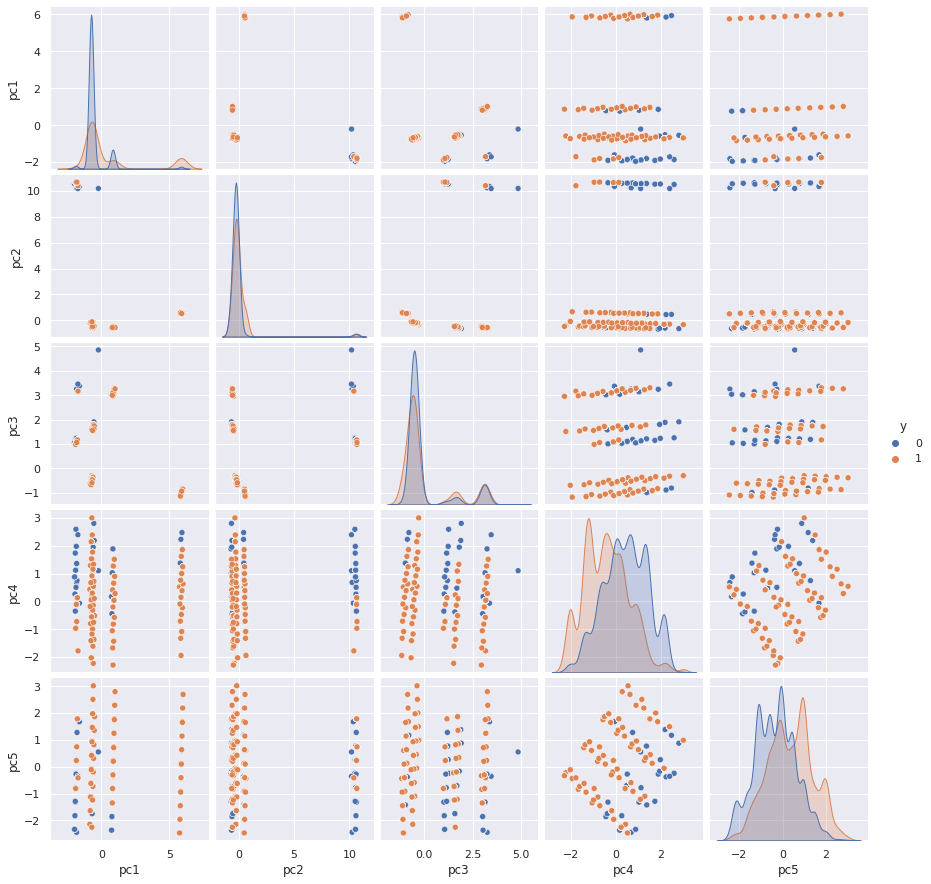

start training...
[LibSVM]evaluation...
score is 0.76375


In [30]:
do_train(cfg=cfg, dataset=bank, model=copy.deepcopy(model), encoder=encoder, scaler=scaler, pca=pca)

## Cross-Validation

In [31]:
do_cross_val(cfg=cfg, dataset=bank, model=copy.deepcopy(model), encoder=encoder, scaler=scaler, pca=pca)

100%|██████████| 10/10 [00:00<00:00, 618.42it/s]

Before sampling Counter({0: 4000, 1: 521})
After sampling Counter({0: 4000, 1: 4000})


f1_micro is 0.76
f1_micro is 0.80
f1_micro is 0.77
f1_micro is 0.79
f1_micro is 0.78
mean of f1_micro: 0.78


## Hyperparameter Tuning

In [32]:
# do_fine_tune(cfg=cfg, dataset=bank, model=copy.deepcopy(model), encoder=encoder, scaler=scaler,
#                 method=TuningMode.GRID_SEARCH)